# CNN training

In [ ]:
import os
import re
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import PIL
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from __future__ import print_function
import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [10]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functions

In [11]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [12]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [13]:
def showImg(img_data):
    if type(img_data) is list:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)
        
        

In [14]:
def resizeCropImg(img_file, target_width, target_height):
    image = tf.keras.preprocessing.image.load_img(img_file)
    width, height = image.size
    left   = width*0.13
    top    = height*0.13
    right  = width*0.87
    bottom = height*0.87
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height))
    return image

In [15]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

# Processing

In [16]:
img_width, img_height = 224, 224

In [17]:
# ## For all deletions, including common and rare
# true_del_file = '/home/rt2776/cnv_espresso/images/true_del_entire_path.list'
# false_del_file = '/home/rt2776/cnv_espresso/images/false_del_entire_path.list'

In [18]:
## For rare deletions
true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del.list'
false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del.list'

In [30]:
# ## For rare duplications
# true_dup_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup.list'
# false_dup_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup.list'

In [53]:
# ## For splited rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del_splits.list'

In [9]:
# ## For splited rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup_splits.list'

### Loading cnv image file paths to list

In [14]:
true_list = [each_file[0] for each_file in fileToList(true_file)]
false_list = [each_file[0] for each_file in fileToList(false_file)]
len(true_list), len(false_list)

(5180, 989)

### Loading images from list to numpy array

In [15]:
false_img_np = loadImgs(false_list, img_width, img_height)
false_img_np.shape

[2021.01.19-06:51:32] Processing 1 ...
[2021.01.19-06:54:01] Done 988.


(989, 224, 224, 3)

In [16]:
true_img_np = loadImgs(true_list, img_width, img_height)
true_img_np.shape

[2021.01.19-06:54:02] Processing 1 ...
[2021.01.19-06:56:36] Processing 1001 ...
[2021.01.19-06:59:12] Processing 2001 ...
[2021.01.19-07:01:52] Processing 3001 ...
[2021.01.19-07:04:12] Processing 4001 ...
[2021.01.19-07:06:41] Processing 5001 ...
[2021.01.19-07:07:04] Done 5179.


(5180, 224, 224, 3)

### Generage labels

In [22]:
true_label = [1 for i in range(0,len(true_img_np))]
false_label = [0 for i in range(0,len(false_img_np))]
print(true_label[0:5], false_label[0:5])
print(len(true_label), len(false_label))

[1, 1, 1, 1, 1] [0, 0, 0, 0, 0]
5180 989


### Combine and shuffle true and false data

In [23]:
combined_img = np.vstack((true_img_np, false_img_np))
combined_label = true_label + false_label

In [24]:
tmp = list(zip(combined_img, combined_label))
random.shuffle(tmp)
combined_img, combined_label = zip(*tmp)
combined_img_np = np.asarray(combined_img)

### Backup or restore

In [85]:
np.save('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_label', combined_label)
np.save('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_img_np', combined_img_np)

In [19]:
# Rare entire deletions
combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_del_label.npy')
combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_del_img_np.npy')

# # rare splited duplications
# combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_label.npy')
# combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_img_np.npy')

In [20]:
combined_img_np.shape

(6169, 224, 224, 3)

### Split dataset into training(80%) and testing(20%) dataset

In [36]:
train_img, test_img, train_label, test_label = train_test_split(combined_img_np,combined_label,test_size=0.2,random_state=0)

In [37]:
train_img.shape, test_img.shape

((4935, 224, 224, 3), (1234, 224, 224, 3))

In [38]:
len(train_label), len(test_label)

(4935, 1234)

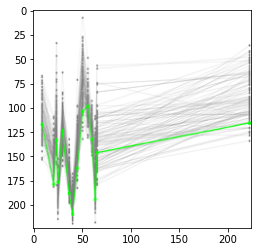

In [39]:
showImg(train_img[1])

### Normalization

In [40]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = train_img.shape[1:]
input_shape = (nRows, nCols, nDims)

In [41]:
# Change to float datatype
train_img = train_img.astype('float32')
test_img = test_img.astype('float32')

# Scale the data to lie between 0 to 1
train_img /= 255
test_img /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_label)
test_labels_one_hot = to_categorical(test_label)

In [42]:
# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [ ]:
np.where(train_label==0)

1


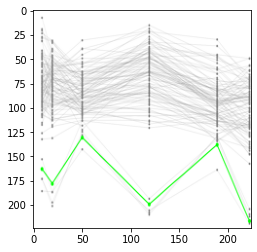

In [75]:
item = random.randint(0,len(train_label))
print(train_label[item])
showImg(train_img[item])

### Train deep nerual network model

In [76]:
model1 = createModel()
batch_size = 20
epochs = 30
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model1.fit(train_img, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_split = 0.2, callbacks=[es, mc])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

In [77]:
model1.evaluate(test_img, test_labels_one_hot)

39/39 [==============================] - 2s 42ms/step - loss: 0.2024 - accuracy: 0.9246


[0.20243984460830688, 0.9246353507041931]

In [104]:
len(test_img)

1234

Text(0.5, 1.0, 'Loss Curves')

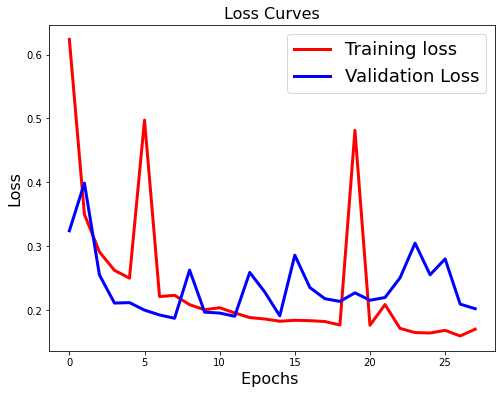

In [78]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

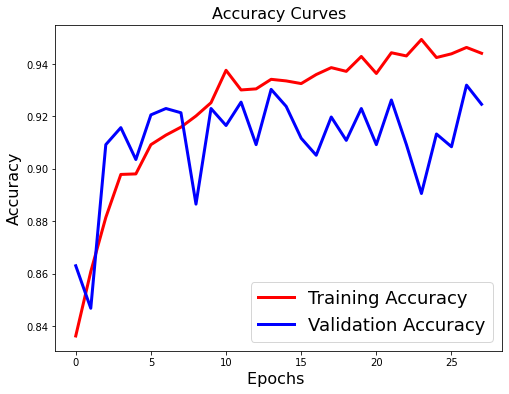

In [79]:
c

In [ ]:
## Try another model

In [97]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu', padding='same', input_shape=input_shape),
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, activation='relu', padding='same', strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax')
  ])

In [98]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [99]:
# print model layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 12)      336       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 24)      10392     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 32)        27680     
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20070600  
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 402       
Total params: 20,109,410
Trainable params: 20,109,410
Non-trainable params: 0
__________________________________________

In [ ]:
history = model.fit(train_img, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_split = 0.2, callbacks=[es, mc])

Epoch 1/30
198/198 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8394
Epoch 00001: val_accuracy did not improve from 0.93193
198/198 [==============================] - 8s 40ms/step - loss: 0.4412 - accuracy: 0.8394 - val_loss: 0.4563 - val_accuracy: 0.8298
Epoch 2/30
197/198 [============================>.] - ETA: 0s - loss: 0.4418 - accuracy: 0.8393
Epoch 00002: val_accuracy did not improve from 0.93193
198/198 [==============================] - 7s 34ms/step - loss: 0.4417 - accuracy: 0.8394 - val_loss: 0.4563 - val_accuracy: 0.8298
Epoch 3/30
196/198 [============================>.] - ETA: 0s - loss: 0.4419 - accuracy: 0.8393
Epoch 00003: val_accuracy did not improve from 0.93193
198/198 [==============================] - 7s 37ms/step - loss: 0.4417 - accuracy: 0.8394 - val_loss: 0.4568 - val_accuracy: 0.8298
Epoch 4/30
198/198 [==============================] - ETA: 0s - loss: 0.4414 - accuracy: 0.8394
Epoch 00004: val_accuracy did not improve from 0.93193


In [ ]:
model.evaluate(test_img, test_labels_one_hot)

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

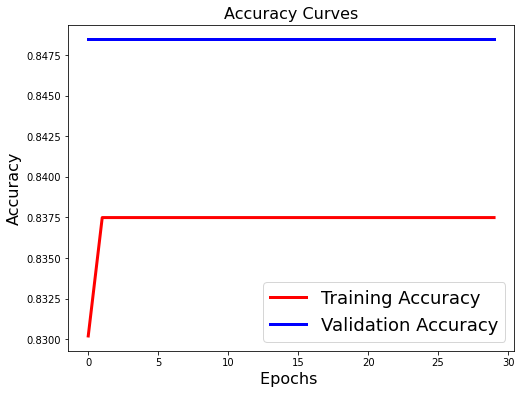

In [103]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Reference:
- load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- https://zhuanlan.zhihu.com/p/51889181